In [21]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.signal import welch

In [22]:
c = 3.0*1e8  # (m/s)
density = 1850  # kg/m³ (SiO2)
kB = 1.380649e-23 # J/K
epsilon_0 = 8.854187817e-12 # (C^2)*(N^-1)*(m^-2)
n_md = 1  # medium refractive index
n_p = 1.46 # particle refractive index
R = 75e-9  # particle radius (m)
T = 297 # K
lamb = 1064*1e-9  # (m)
NA = 0.13
P = 1000*1e-3 # Total Power (W), and here I'm considering that the two beams are of same power, half of P actually
m_gas = 4.81e-26 # molecular mass of air
Pressure_atm = 1013.25 #mbar (=1 atm)
Pressure = (Pressure_atm)/101.325
eta_air = 18.27e-6 # Pa # (J.T.R.Watson (1995)).
d_gas = 0.372e-9 #m #(Sone (2007)), ρSiO2

In [23]:
print(Pressure, "milibar")

10.0 milibar


In [24]:
k = 2*np.pi/lamb
w_0 = lamb/(np.pi*NA) # incident beam waist (m)
#w_0 = 9*1e-6
m_rri = n_p/n_md #relative refractive index
z_R = (np.pi * w_0**2) / lamb #rayleigh range #checar isso aqui!!!!!!!!!!!!!!!
volume = (4/3) * np.pi * (R**3)
m = density * volume  # kg

In [25]:
def Gamma_env(Pressure_mbar):
    def mfp(P_gas):
        mfp_val = kB*T/(2**0.5*np.pi*d_gas**2*P_gas)
        return mfp_val
    
    Pressure_pascals = 100*Pressure_mbar
    s = mfp(Pressure_pascals)
    K_n = s/R
    c_K = 0.31*K_n/(0.785 + 1.152*K_n + K_n**2)
    gamma = 6*np.pi*eta_air*R/m * 0.619/(0.619 + K_n) * (1+c_K)
    return gamma #Isso está em Hz

gamma_hz = Gamma_env(Pressure)

In [26]:
N = 20_000_000
dt = 1e-8
t = np.linspace(0,dt*N,N)
x = np.linspace(-5*1e-6,5*1e-6,len(t))
y = np.linspace(-5*1e-6,5*1e-6,len(t))
z = np.linspace(-1e-6, 0.05, len(t))

In [27]:
beta = 2e5

@njit(fastmath=True)
def F_opt(x,y,z,t):
    alpha_fac = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))
    F_0 = (P/(2*np.pi*(w_0**2)))*alpha_fac

    exp_term = np.exp(-2 * (x**2 + y**2) / (w_0**2))
    cos_term = np.cos(2 * k * z - beta * t**2)
    sin_term = np.sin(2 * k * z - beta * t**2)

    fx = F_0*((-4 * x / w_0**2) * exp_term * cos_term)
    fy = F_0*((-4 * y / w_0**2) * exp_term * cos_term)
    fz = F_0*(-2 * k * exp_term * sin_term)

    return fx, fy, fz

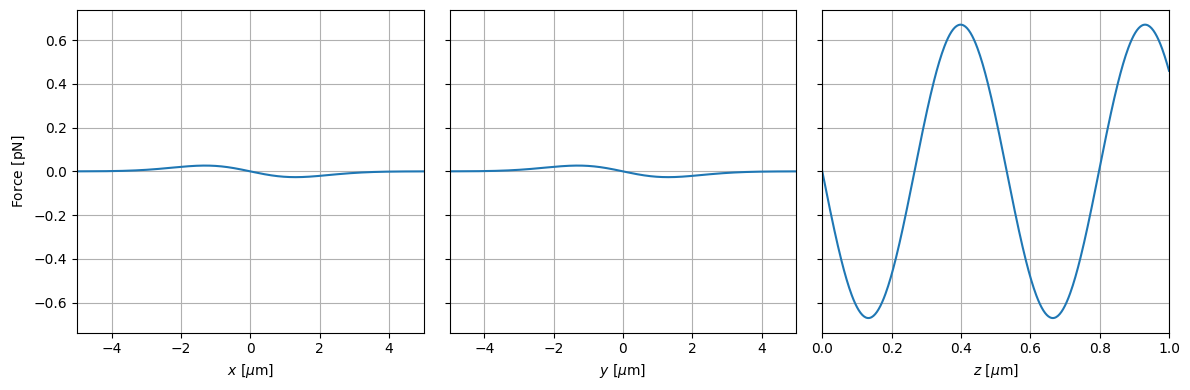

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4),sharey=True)

axs[0].plot(x*1e6,F_opt(x,0,0,0)[0]*1e12)
axs[0].set_xlabel(r'$x\ \left[\mu\mathrm{m}\right]$')
axs[0].grid(True)
axs[0].set_xlim(-5,5)
axs[0].set_ylabel(r'Force $\left[\mathrm{pN}\right]$')

axs[1].plot(y*1e6,F_opt(0,y,0,0)[1]*1e12)
axs[1].set_xlabel(r'$y\ \left[\mu\mathrm{m}\right]$')
axs[1].grid(True)
axs[1].set_xlim(-5,5)

axs[2].plot(z*1e6,F_opt(0,0,z,0)[2]*1e12)
axs[2].set_xlabel(r'$z\ \left[\mu\mathrm{m}\right]$')
axs[2].grid(True)
axs[2].set_xlim(0,1)

plt.tight_layout()
plt.show()

In [29]:
@njit(fastmath=True)
def dx_dt(v):
    return v

@njit(fastmath=True)
def dv_dt(pos,F_total_z,v):
    return F_total_z/m - gamma_hz*v

In [30]:
@njit(fastmath=True)
def runge_kutta(v_init, pos_init):
    positions = np.zeros((len(t), 3))
    velocities = np.zeros((len(t), 3))
    
    positions[0, :] = pos_init
    velocities[0, :] = v_init

    for i in range(len(t) - 1):
        if i > len(t)*1.1:
            Fs = np.array(F_opt(positions[i, 0], positions[i, 1], positions[i, 2],dt*len(t)*0.9))
        else:
            Fs = np.array(F_opt(positions[i, 0], positions[i, 1], positions[i, 2],dt*i))

        #Fs = np.array(F_opt(positions[i, 0], positions[i, 1], positions[i, 2],i*dt))
        
        k1_pos = velocities[i] * dt
        k1_v = np.array([dv_dt(positions[i, j], Fs[j], velocities[i, j]) for j in range(3)]) * dt

        k2_pos = (velocities[i] + 0.5 * k1_v) * dt
        k2_v = np.array([dv_dt(positions[i, j] + 0.5 * k1_pos[j], Fs[j], velocities[i, j] + 0.5 * k1_v[j]) for j in range(3)]) * dt

        k3_pos = (velocities[i] + 0.5 * k2_v) * dt
        k3_v = np.array([dv_dt(positions[i, j] + 0.5 * k2_pos[j], Fs[j], velocities[i, j] + 0.5 * k2_v[j]) for j in range(3)]) * dt

        k4_pos = (velocities[i] + k3_v) * dt
        k4_v = np.array([dv_dt(positions[i, j] + k3_pos[j], Fs[j], velocities[i, j] + k3_v[j]) for j in range(3)]) * dt

        positions[i + 1] = positions[i] + (1.0 / 6.0) * (k1_pos + 2 * k2_pos + 2 * k3_pos + k4_pos)
        velocities[i + 1] = velocities[i] + (1.0 / 6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

        thermal_noise = np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal(0, 1, 3) * np.sqrt(dt) / m
        velocities[i + 1] += thermal_noise

    return positions, velocities


In [31]:
x0 = np.array([0.0, 0.0, 0.0]) #(dt)*np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
v0 = np.array([0.0, 0.0, 0.0]) #np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m

positions,velocities = runge_kutta(v0,x0)

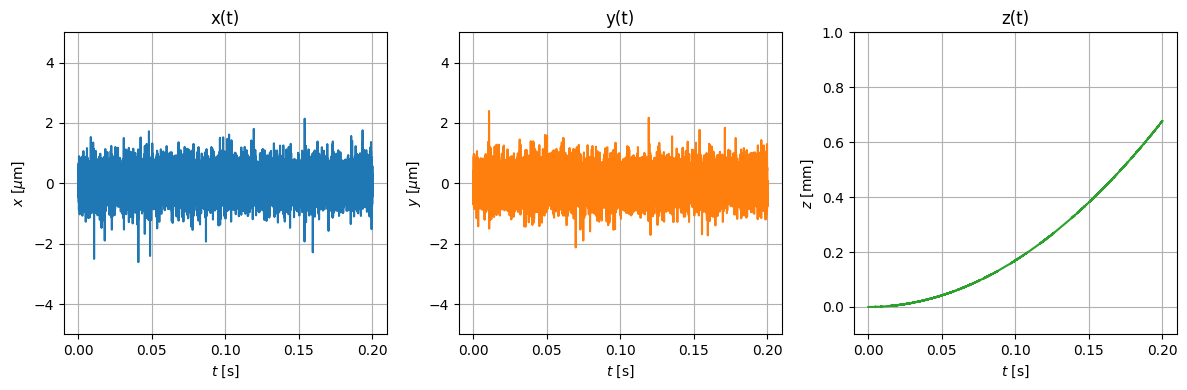

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
l = 0

axs[0].plot(t, positions[:,0] * 1e6, color='#1f77b4')
axs[0].set_ylim(-5, 5)
axs[0].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[0].set_ylabel(r'$x\ \left[\mu\mathrm{m}\right]$')
axs[0].set_title("x(t)")
axs[0].grid(True)

axs[1].plot(t, positions[:,1] * 1e6, color='#ff7f0e')
axs[1].set_ylim(-5, 5)
axs[1].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[1].set_ylabel(r'$y\ \left[\mu\mathrm{m}\right]$')
axs[1].set_title("y(t)")
axs[1].grid(True)

axs[2].plot(t, positions[:,2]*1e3, color='#2ca02c')
axs[2].set_ylim(-0.1, 1)
axs[2].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[2].set_ylabel(r'$z\ \left[\mathrm{mm}\right]$')
axs[2].set_title("z(t)")
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [33]:
f, Pxx = welch(positions[:,0], fs=1/dt, window='hamming', nperseg=len(positions[:,0]))
f, Pyy = welch(positions[:,1], fs=1/dt, window='hamming', nperseg=len(positions[:,1]))
f, Pzz = welch(positions[:,2], fs=1/dt, window='hamming', nperseg=len(positions[:,2]))

/var/folders/d6/n5kkxz3125708zjn5q4h4bhh0000gn/T/ipykernel_14708/3348948629.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


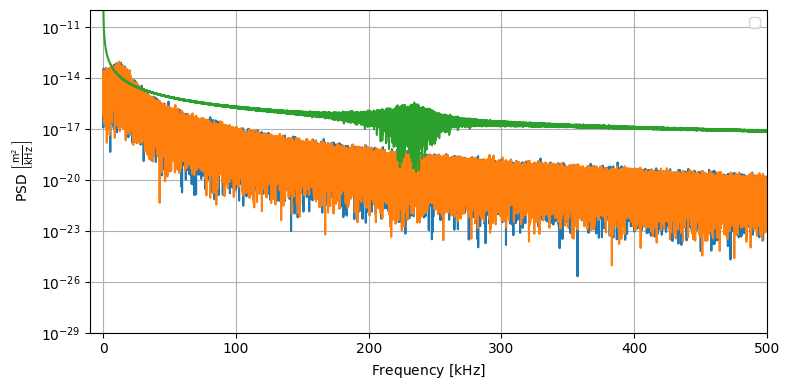

In [34]:
plt.figure(figsize=(8, 4))

plt.plot(f[1:]/1e3,Pxx[1:]*1e3)
plt.plot(f[1:]/1e3,Pyy[1:]*1e3)
plt.plot(f[1:]/1e3,Pzz[1:]*1e3)

plt.yscale('log')
#plt.xscale('log')
plt.ylim(1e-29,1e-10)
plt.xlim(-10,5e5/1e3)
plt.xlabel(r'Frequency $\left[\mathrm{kHz}\right]$')
plt.ylabel(r'PSD $\left[\frac{\mathrm{m}^2}{\mathrm{kHz}}\right]$')

plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
#x0 = np.array([0.0, 0.0, 0.0]) #(dt)*np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
#v0 = np.array([0.0, 0.0, 0.0]) #np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
#fs = 1/dt
#
#P = []
#V = []
#F = []
#PSDs = []
#num_PSD = 1
#for i in range(num_PSD):
#    positions,velocities = runge_kutta(v0,x0)
#    P.append(positions)
#    V.append(velocities)
#
#    f, Pxx = welch(positions[:,0], fs=fs, window='hamming', nperseg=len(positions[:,0]))
#    f, Pyy = welch(positions[:,1], fs=fs, window='hamming', nperseg=len(positions[:,1]))
#    f, Pzz = welch(positions[:,2], fs=fs, window='hamming', nperseg=len(positions[:,2]))
#    
#    F.append(f)
#    PSDs.append([Pxx,Pyy,Pzz])

In [36]:
#fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#
#l = 0
#
#axs[0].plot(t, P[l][:,0] * 1e6, color='#1f77b4')
#axs[0].set_ylim(-3, 3)
#axs[0].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
#axs[0].set_ylabel(r'$x\ \left[\mu\mathrm{m}\right]$')
#axs[0].set_title("x(t)")
#axs[0].grid(True)
#
#axs[1].plot(t, P[l][:,1] * 1e6, color='#ff7f0e')
#axs[1].set_ylim(-3, 3)
#axs[1].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
#axs[1].set_ylabel(r'$y\ \left[\mu\mathrm{m}\right]$')
#axs[1].set_title("y(t)")
#axs[1].grid(True)
#
#axs[2].plot(t, P[l][:,2] * 1e6, color='#2ca02c')
#axs[2].set_ylim(-0.1, 0.1)
#axs[2].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
#axs[2].set_ylabel(r'$z\ \left[\mu\mathrm{m}\right]$')
#axs[2].set_title("z(t)")
#axs[2].grid(True)
#
#plt.tight_layout()
#plt.show()

In [37]:
#mean_PSD = [np.zeros_like(PSDs[0][0]), np.zeros_like(PSDs[0][1]), np.zeros_like(PSDs[0][2])]
#
#for j in range(num_PSD):
#    for i in range(3):
#        mean_PSD[i] += PSDs[j][i]
#
#for i in range(3):
#    mean_PSD[i] /= num_PSD

In [38]:
#idx_max_x = np.argmax(mean_PSD[0][:])  # +1 porque estamos usando Pxx[1:], arrancando o primeiro ponto por conta do erro gerado por ser igual a zero
#idx_max_y = np.argmax(mean_PSD[1][:])
#idx_max_z = np.argmax(mean_PSD[2][25:]) + 25
#f_max = [f[idx_max_x],f[idx_max_y],f[idx_max_z]]
#
#plt.figure(figsize=(8, 4))
#
#plt.plot(f[1:]/1e3,mean_PSD[0][1:]*1e3)
#plt.plot(f[1:]/1e3,mean_PSD[1][1:]*1e3)
#plt.plot(f[1:]/1e3,mean_PSD[2][1:]*1e3)
#
#plt.yscale('log')
##plt.xscale('log')
#plt.ylim(1e-29,1e-10)
#plt.xlim(-10,1e5/1e3)
#plt.xlabel(r'Frequency $\left[\mathrm{kHz}\right]$')
#plt.ylabel(r'PSD $\left[\frac{\mathrm{m}^2}{\mathrm{kHz}}\right]$')
#
##plt.axvline(f_max[0]/1e3, color='r', linestyle='--',label=fr'Resonance frequency in x and y: {f_max[0]/1e3:.1f} $\mathrm{{kHz}}$')
###plt.axvline(f_max[1]/1e3, color='r', linestyle='--',label=fr'Resonance frequency in y: {f_max[1]/1e3:.1f} $\mathrm{{kHz}}$')
##plt.axvline(f_max[2]/1e3, color='r', linestyle='--',label=fr'Resonance frequency in z: {f_max[2]/1e3:.1f} $\mathrm{{kHz}}$')
#
#plt.legend(loc="upper right")
#plt.grid(True)
#plt.tight_layout()
#plt.show()